## Extrated fMRI -> T1w 

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_194156/3416550445.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


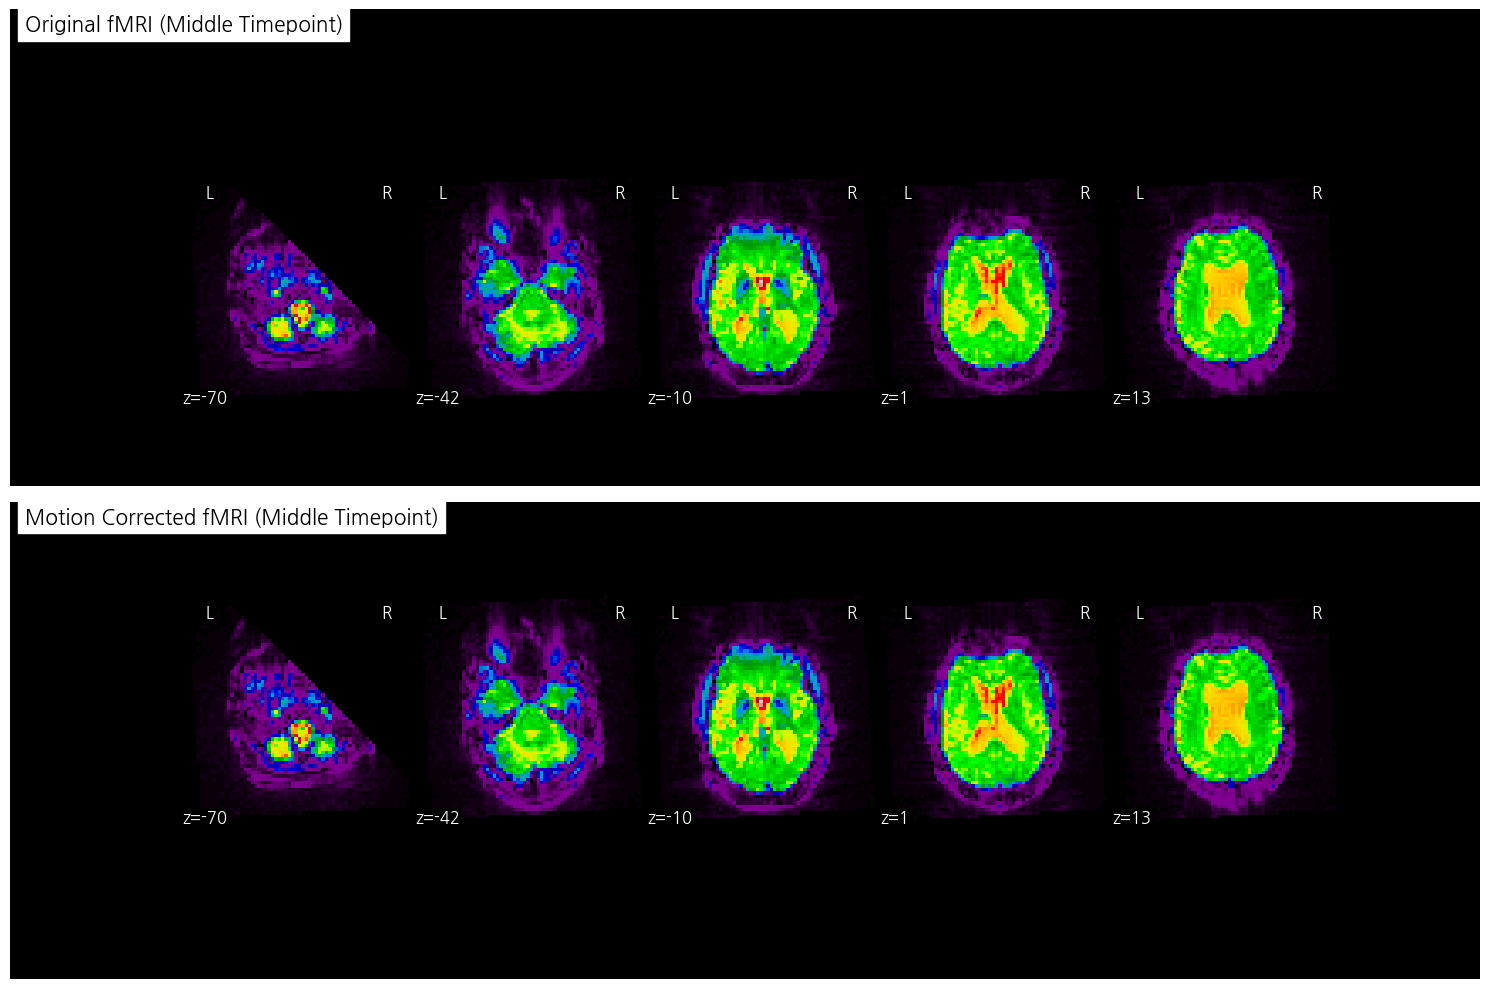

Motion parameters file not found: /home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample/mc_fmri.par
Motion Correction 및 시각화 완료


In [8]:
import os
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/func2/NIFTI/sub-OAS30016_ses-d0021_task-rest_run-02_bold.nii.gz'
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

mc_output = os.path.join(output_dir, "mc_fmri")
mc_command = f"mcflirt -in {fmri_file} -out {mc_output} -stats"
subprocess.run(mc_command, shell=True, check=True)

original_img = nib.load(fmri_file)
mc_img = nib.load(f"{mc_output}.nii.gz")

mid_timepoint = original_img.shape[3] // 2

original_data = original_img.slicer[..., mid_timepoint]
mc_data = mc_img.slicer[..., mid_timepoint]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plotting.plot_epi(original_data, display_mode='z', cut_coords=5, title="Original fMRI (Middle Timepoint)", axes=ax1)
plotting.plot_epi(mc_data, display_mode='z', cut_coords=5, title="Motion Corrected fMRI (Middle Timepoint)", axes=ax2)

plt.tight_layout()
plt.show()

# Motion parameters 
mc_par_file = f"{mc_output}.par"

if os.path.exists(mc_par_file):
    motion_params = np.loadtxt(mc_par_file)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Translation parameters
    ax1.plot(motion_params[:, 0], label='x')
    ax1.plot(motion_params[:, 1], label='y')
    ax1.plot(motion_params[:, 2], label='z')
    ax1.set_title('Translation Parameters')
    ax1.set_xlabel('Timepoint')
    ax1.set_ylabel('Translation (mm)')
    ax1.legend()

    # Rotation parameters
    ax2.plot(motion_params[:, 3], label='x')
    ax2.plot(motion_params[:, 4], label='y')
    ax2.plot(motion_params[:, 5], label='z')
    ax2.set_title('Rotation Parameters')
    ax2.set_xlabel('Timepoint')
    ax2.set_ylabel('Rotation (radians)')
    ax2.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"Motion parameters file not found: {mc_par_file}")

print("Motion Correction 및 시각화 완료")

In [1]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/func2/NIFTI/sub-OAS30016_ses-d0021_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/anat2/NIFTI/sub-OAS30016_ses-d0021_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

os.makedirs(output_dir, exist_ok=True)

fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {fmri_file} {bet_output} -F -f 0.3 -m"
subprocess.run(bet_command, shell=True, check=True)

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print("Starting FLIRT registration...")
start_time = time.time()
first_volume = nib.Nifti1Image(masked_fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {first_volume_path} -ref {t1_file} -omat {flirt_mat_output} -cost corratio -dof 6"
subprocess.run(flirt_command, shell=True, check=True)

flirt_output = os.path.join(output_dir, "func_to_struct")
apply_xfm_command = f"applywarp --in={masked_fmri_path} --ref={t1_file} --premat={flirt_mat_output} --out={flirt_output}"
subprocess.run(apply_xfm_command, shell=True, check=True)
print(f"FLIRT registration and application completed in {time.time() - start_time:.2f} seconds")

print("Starting FNIRT registration...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_file} --ref={mni_template} --aff={flirt_mat_output} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"FNIRT registration completed in {time.time() - start_time:.2f} seconds")

print("Applying warp to fMRI data...")
start_time = time.time()
apply_warp_command = f"applywarp --in={flirt_output} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Warp application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Starting FLIRT registration...


ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary points!
ERROR::set_bbr_seg: could not find any boundary 

KeyboardInterrupt: 

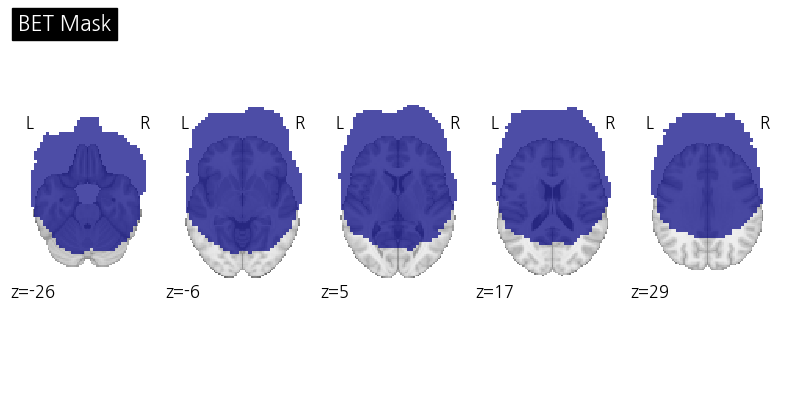

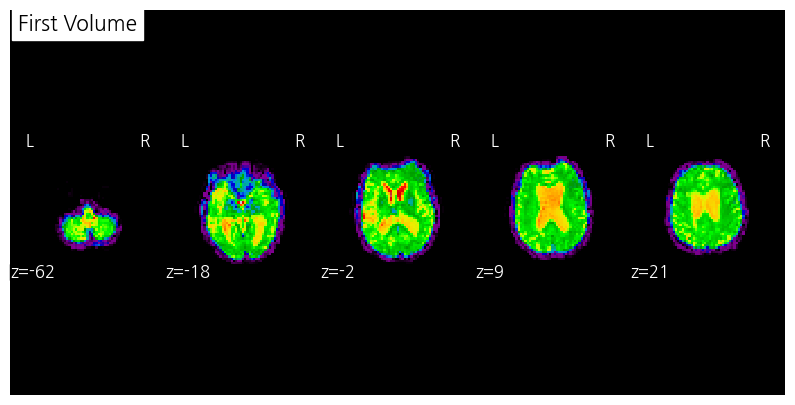

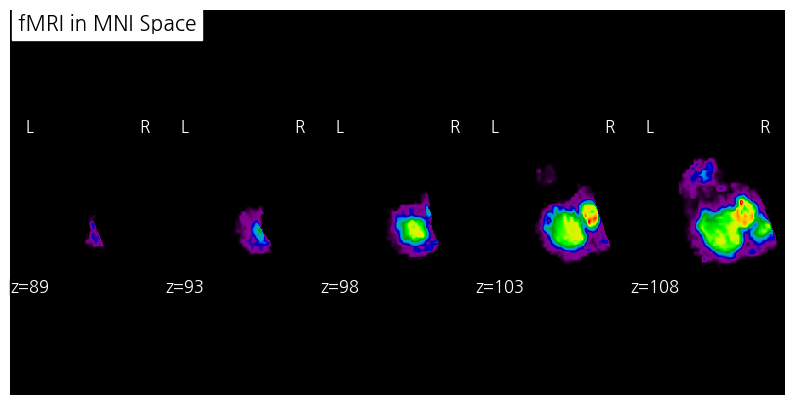

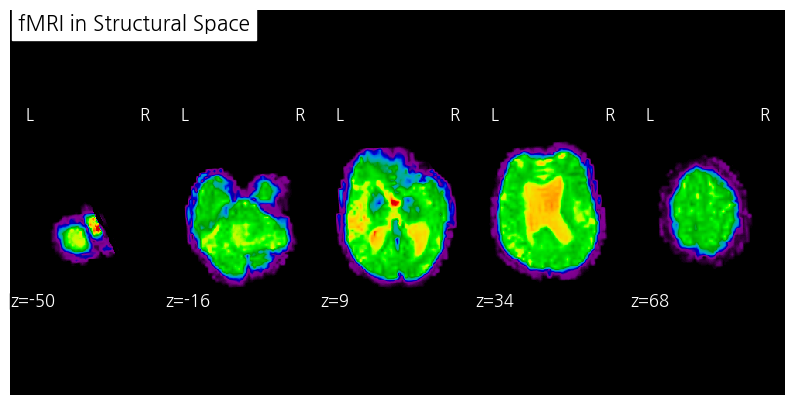

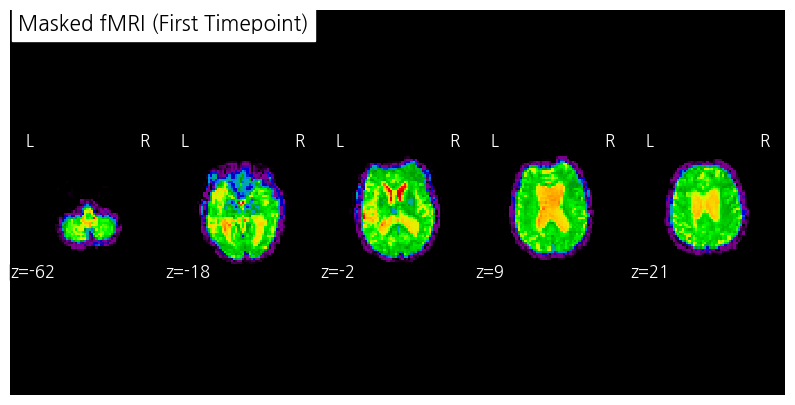

Visualization completed.


In [6]:
import os
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

result_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

bet_mask = os.path.join(result_dir, 'bet_output_mask.nii.gz')
first_volume = os.path.join(result_dir, 'first_volume.nii.gz')
func_to_mni = os.path.join(result_dir, 'func_to_mni.nii.gz')
func_to_struct = os.path.join(result_dir, 'func_to_struct.nii.gz')
masked_fmri = os.path.join(result_dir, 'masked_fmri.nii.gz')

# 1. BET 마스크 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_roi(bet_mask, display_mode='z', cut_coords=5, title="BET Mask", axes=ax)
plt.show()

# 2. 첫 번째 볼륨 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(first_volume, display_mode='z', cut_coords=5, title="First Volume", axes=ax)
plt.show()

# 3. MNI 공간으로 변환된 fMRI 데이터 시각화
func_to_mni_img = nib.load(func_to_mni)
if len(func_to_mni_img.shape) == 4:
    func_to_mni_data = func_to_mni_img.slicer[..., 0]
else:
    func_to_mni_data = func_to_mni_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(func_to_mni_data, display_mode='z', cut_coords=5, title="fMRI in MNI Space", axes=ax)
plt.show()

# 4. 구조적 공간으로 변환된 fMRI 데이터 시각화
func_to_struct_img = nib.load(func_to_struct)
if len(func_to_struct_img.shape) == 4:
    func_to_struct_data = func_to_struct_img.slicer[..., 0]
else:
    func_to_struct_data = func_to_struct_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(func_to_struct_data, display_mode='z', cut_coords=5, title="fMRI in Structural Space", axes=ax)
plt.show()

# 5. 마스킹된 fMRI 데이터 시각화 (첫 번째 시간점)
masked_fmri_img = nib.load(masked_fmri)
if len(masked_fmri_img.shape) == 4:
    masked_fmri_data = masked_fmri_img.slicer[..., 0]
else:
    masked_fmri_data = masked_fmri_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(masked_fmri_data, display_mode='z', cut_coords=5, title="Masked fMRI (First Timepoint)", axes=ax)
plt.show()

print("Visualization completed.")

# BBR 적용

In [3]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/func2/NIFTI/sub-OAS30016_ses-d0021_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/anat2/NIFTI/sub-OAS30016_ses-d0021_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

os.makedirs(output_dir, exist_ok=True)

fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

if not os.path.exists(t1_file):
    print(f"Error: T1 file not found at {t1_file}")
    exit(1)

# fMRI 데이터에 대한 뇌 추출
print("Performing brain extraction on fMRI data...")
bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {fmri_file} {bet_output} -F -f 0.3 -m"
subprocess.run(bet_command, shell=True, check=True)

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

# T1 이미지에 대한 뇌 추출
print("Performing brain extraction on T1 image...")
t1_brain = os.path.join(output_dir, "t1_brain")
bet_t1_command = f"bet {t1_file} {t1_brain} -f 0.3"
subprocess.run(bet_t1_command, shell=True, check=True)

# FAST를 사용하여 T1 뇌 이미지 분할
print("Segmenting T1 brain image...")
t1_segmented = os.path.join(output_dir, "t1_segmented")
fast_command = f"fast -t 1 -n 3 -H 0.1 -I 4 -l 20.0 -o {t1_segmented} {t1_brain}.nii.gz"
subprocess.run(fast_command, shell=True, check=True)

# 백질 분할 이미지 경로
wm_seg = f"{t1_segmented}_pve_2.nii.gz"

print("Starting FLIRT registration with BBR...")
start_time = time.time()
first_volume = nib.Nifti1Image(masked_fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {first_volume_path} -ref {t1_brain}.nii.gz -omat {flirt_mat_output} -cost bbr -wmseg {wm_seg} -dof 6"
subprocess.run(flirt_command, shell=True, check=True)

flirt_output = os.path.join(output_dir, "func_to_struct")
apply_xfm_command = f"applywarp --in={masked_fmri_path} --ref={t1_brain}.nii.gz --premat={flirt_mat_output} --out={flirt_output}"
subprocess.run(apply_xfm_command, shell=True, check=True)
print(f"FLIRT registration and application completed in {time.time() - start_time:.2f} seconds")

print("Starting FNIRT registration...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_brain}.nii.gz --ref={mni_template} --aff={flirt_mat_output} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"FNIRT registration completed in {time.time() - start_time:.2f} seconds")

print("Applying warp to fMRI data...")
start_time = time.time()
apply_warp_command = f"applywarp --in={flirt_output} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Warp application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Performing brain extraction on fMRI data...
Performing brain extraction on T1 image...
Segmenting T1 brain image...
Starting FLIRT registration with BBR...
FLIRT registration and application completed in 816.99 seconds
Starting FNIRT registration...
FNIRT registration completed in 1179.28 seconds
Applying warp to fMRI data...
Warp application completed in 414.59 seconds
fMRI preprocessing pipeline completed successfully.


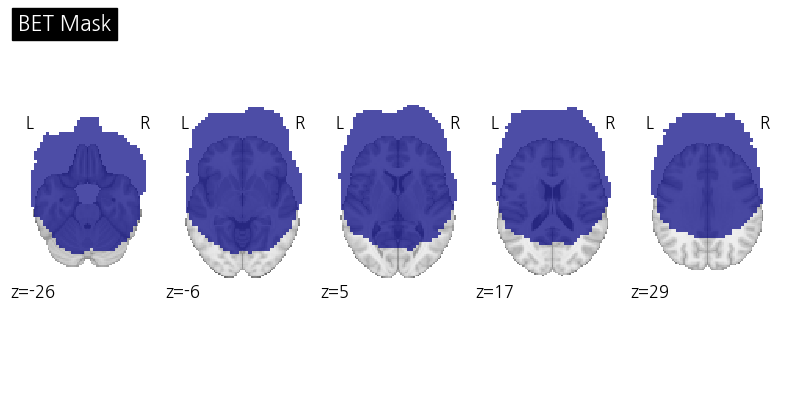

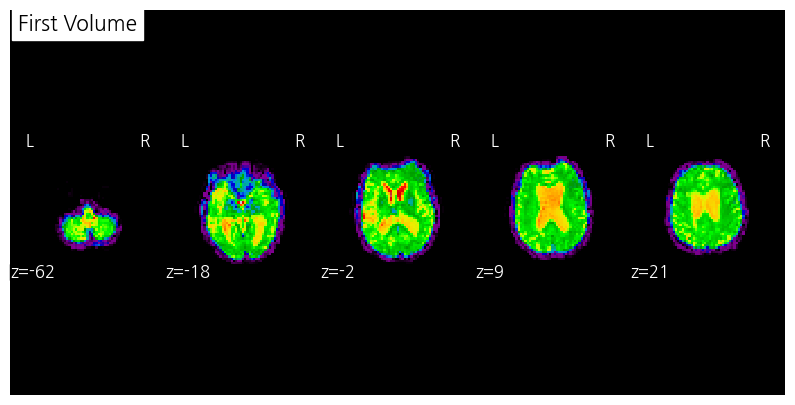

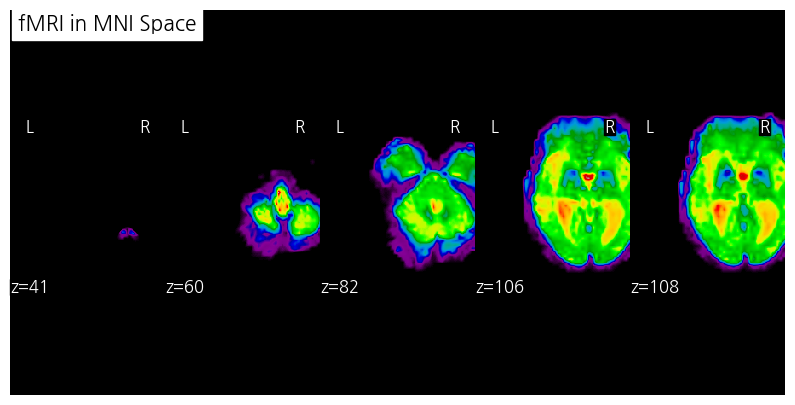

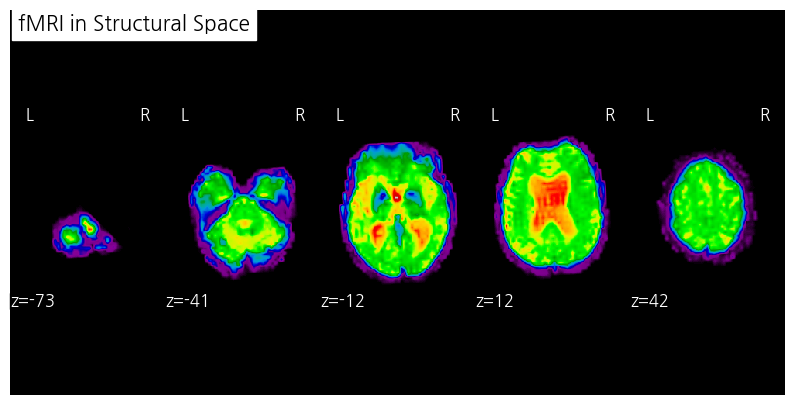

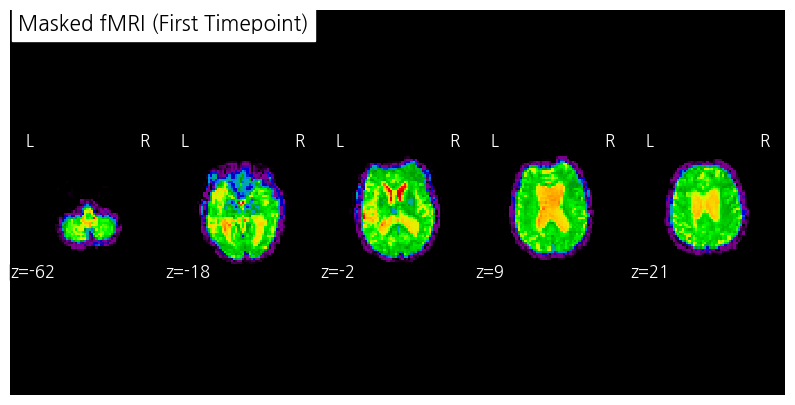

Visualization completed.


In [4]:
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

result_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

bet_mask = os.path.join(result_dir, 'bet_output_mask.nii.gz')
first_volume = os.path.join(result_dir, 'first_volume.nii.gz')
func_to_mni = os.path.join(result_dir, 'func_to_mni.nii.gz')
func_to_struct = os.path.join(result_dir, 'func_to_struct.nii.gz')
masked_fmri = os.path.join(result_dir, 'masked_fmri.nii.gz')

# 1. BET 마스크 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_roi(bet_mask, display_mode='z', cut_coords=5, title="BET Mask", axes=ax)
plt.show()

# 2. 첫 번째 볼륨 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(first_volume, display_mode='z', cut_coords=5, title="First Volume", axes=ax)
plt.show()

# 3. MNI 공간으로 변환된 fMRI 데이터 시각화
func_to_mni_img = nib.load(func_to_mni)
if len(func_to_mni_img.shape) == 4:
    func_to_mni_data = func_to_mni_img.slicer[..., 0]
else:
    func_to_mni_data = func_to_mni_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(func_to_mni_data, display_mode='z', cut_coords=5, title="fMRI in MNI Space", axes=ax)
plt.show()

# 4. 구조적 공간으로 변환된 fMRI 데이터 시각화
func_to_struct_img = nib.load(func_to_struct)
if len(func_to_struct_img.shape) == 4:
    func_to_struct_data = func_to_struct_img.slicer[..., 0]
else:
    func_to_struct_data = func_to_struct_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(func_to_struct_data, display_mode='z', cut_coords=5, title="fMRI in Structural Space", axes=ax)
plt.show()

# 5. 마스킹된 fMRI 데이터 시각화 (첫 번째 시간점)
masked_fmri_img = nib.load(masked_fmri)
if len(masked_fmri_img.shape) == 4:
    masked_fmri_data = masked_fmri_img.slicer[..., 0]
else:
    masked_fmri_data = masked_fmri_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(masked_fmri_data, display_mode='z', cut_coords=5, title="Masked fMRI (First Timepoint)", axes=ax)
plt.show()

print("Visualization completed.")